In [24]:
import numpy as np
import pandas as pd
from scipy.stats import hypergeom
import matplotlib.pyplot as plt
import math
import random
from matplotlib.ticker import MaxNLocator
import multiprocessing
from functools import partial
from matplotlib import rc
from matplotlib import gridspec

rc('text', usetex=True)

## When to stop screening in machine-learning assisted systematic reviews

In systematic reviews, and other evidence synthesis tasks, we start off by searching for documents. We retrieve a number of documents, of which some are **relevant** and some are not. We employ screening to find the subset of papers which are **relevant**.

Active learning systems use machine learning to iteratively prioritise the documents screened by humans. In theory, a high recall should be achieved before seeing all documents (saving work), but without *a priori* knowledge of the number of relevant documents, we don't know when what level or recall has been achieved.

We propose to interrupt machine learning and begin sampling from the remaining unseen documents. We devise a test to be run after each draw which should tell us the probability that a given level of recall has been achieved.

First we define some parameters:

$N_T$ is the total number of papers to be screened

$\rho_{tot}$ is the number of these papers which are **relevant** to the systematic review, but we don't know this yet

$\rho_{seen}$ is the number of relevant documents seen by the human screener

$\tau$ is **Recall**, this is defined by the proportion of total **relevant** documents seen by the human screener

(1) $\tau = \frac{\rho_{seen}}{\rho_{tot}}$

We set these up with some hypothetical values, and define a function to estimate recall

In [2]:
N_T = 1000
r_tot = 200
r_seen = 175

def get_recall(r_seen, r_tot):
    return r_seen/r_tot

get_recall(r_seen,r_tot)

0.875

## Random sampling

### Setup 

After several iterations of machine learning, we begin to sample from the remaining documents

$N_{ML}$ is the number of documents seen during the machine learning process

$\rho_{ML}$ is the number of **relevant** documents seen during the machine learning process

$N_s$ is the number of documents remaining when sampling begins $N_s = N_T - N_{ML}$

$K$ is the number of **relevant** documents remaining when sampling begins. We still don't know know what this is.

We do know that it forms part of the total number of relevant documents 

(2) $\rho_{tot} = \rho_{ML} + K$

### On each sample

Then, after each new document is sampled 

$n$ is the number of documents drawn

$k$ is the number of **relevant** documents drawn

The number of **relevant** documents seen is simply the sum of **relevant** documents during ML and during sampling

(3) $\rho_{seen} = \rho_{ML} + k$

With equations (2) and (3) we can be break down what goes into recall:

(4) $\tau = \frac{\rho_{ML}+k}{\rho_{ML}+K}$ 

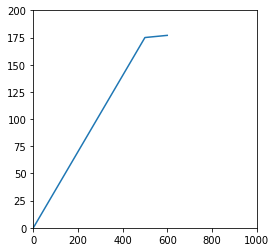

Knowing all paramaters, we can see that recall here is 0.885


In [3]:
# Lets start with a situation where we have seen half the documents, and 95% of relevant documents
N_ML = 500
r_ML = 175
N_s = N_T - N_ML
K = r_tot - r_ML

# And imagine that we sample 100 further documents and observe 2 relevant documents
n = 100
k = 2

r_seen = r_ML + k

tau = (r_ML+k)/(r_ML+K)

#let's plot our progress in machine learning, and since the random sample started
fig, ax = plt.subplots(figsize=(4,4))
ax.plot([0,N_ML, N_s+n],[0,r_ML, r_seen])
ax.set_xlim(0,N_T)
ax.set_ylim(0,r_tot)

plt.show()

print(f"Knowing all paramaters, we can see that recall here is {tau}")

## Hypothesis Testing

We develop a hypothesis test to help us decide when to stop screening. We want to rule out the possibility that the recall we actually achieved is below a given level which we deem acceptable: our target recall.

$\hat{\tau}$ is our recall target

Which means our hypothesis test is as follows:

(5) $H_0: \tau \leq \hat{\tau}$

Now, when we are sampling without replacement, we can use the hypergeometric distribution to find out the probability of observing $k$ **relevant** documents in a sample of $n$ documents from a population of $N$ documents of which $K$ are relevant. We know that $k$ is distributed hypergeometrically: $X \sim Hypergeometric(N, K, n)$

We introduce a hypothetical value for $K$, which we call $\hat{K}$. This represents the minimum number of **relevant** documents remaining at the start of sampling compatible with our null hypothesis that recall is below our target.

(7) $\hat{K} = \lceil \frac{\rho_{seen}}{\hat{\tau}}-\rho_{ML} \rceil$, or the total number of **relevant** results given the total **relevant** results seen and the target recall, minus the number of relevant results seen since sampling began, rounded up to the next integer

In other words, if $K$ were really $\hat{K}$ or higher, then we would have missed our recall target, but if $K$ is any lower than $\hat{K}$, then we have achieved our target 

In [4]:
# Returning to our numerical example, let's set the target recall to .95 and get K_hat
tau_target=.95
def get_K_hat(r_seen,tau_target,r_ML):
    return(math.ceil(r_seen/tau_target - r_ML))

K_hat = get_K_hat(r_seen,tau_target,r_ML)

print(f"given that r_seen is {r_seen}, tau_target is {tau_target}, and r_ML is {r_ML}, K_hat = {K_hat}")

print(f"if K were {K_hat}, r_tot would be {r_ML+K_hat}, recall would be {r_seen/(r_ML+K_hat)}")


given that r_seen is 177, tau_target is 0.95, and r_ML is 175, K_hat = 12
if K were 12, r_tot would be 187, recall would be 0.946524064171123


### Null Hypothesis

Our null hypothesis is therefore that the true number of relevant documents in the sample is greater than or equal to our hypothetical value:

(8) $H_0 : K \geq \hat{K}$

Our alternative hypothesis is that


We test this by calculating the probability of observing $k$ or fewer **relevant** from the hypergeometric distribution given by $\hat{K}$

(9) $ P(X \leq k)$, where $X \sim Hypergeometric(N,\hat{K},n), $

If the probability of observing $k$ or fewer relevant documents given our null hypothesis is low, then we can reject the null hypothesis 

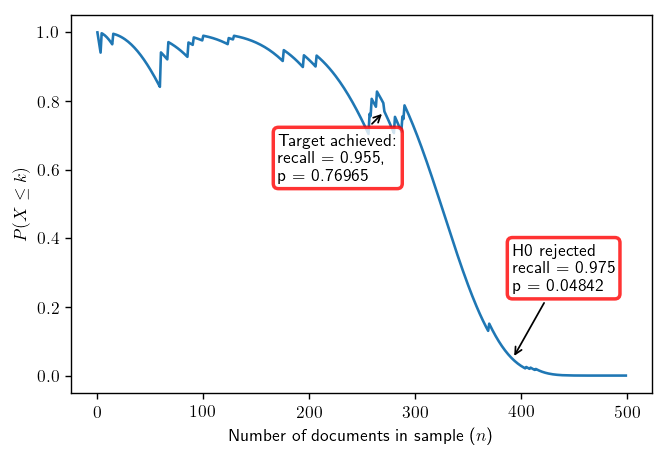

In [18]:
# Let's create a sample
sample = np.zeros(N_s)
sample[:K] = 1
np.random.shuffle(sample)

vec_get_K_hat = np.vectorize(get_K_hat)

## We can define a function for simulating drawing from this sample
def draw_sample(x,sample=sample):
    np.random.shuffle(sample) # each time we shuffle the sample
    r_seen = r_ML+sample.cumsum() 
    tau = r_seen/r_tot
    K_hat = vec_get_K_hat(r_seen,tau_target,r_ML)
    p = hypergeom.cdf(sample.cumsum(), N_s, K_hat, np.arange(N_s))
    i = np.argmax(tau>tau_target) # The first iteration where we 
    target_achievement = {"tau":tau[i], "i":i,"p":p[i], "K_hat":K_hat[i]}
    i = np.argmax(p<0.05)
    H0_rejection = {"tau":tau[i], "i":i,"p":p[i], "K_hat":K_hat[i]}
    return p, H0_rejection, target_achievement

y, H0_rejection, target_achievement = draw_sample(0,sample)

fig, ax = plt.subplots(dpi=150)
bbox_props = dict(boxstyle="round,pad=0.3", ec="red",fc="white",alpha=0.8, lw=2)
ax.annotate(
    f"Target achieved:\nrecall = {target_achievement['tau']},\np = {target_achievement['p']:.5f}",
    (target_achievement['i'],target_achievement['p']),
    (target_achievement['i']-100,target_achievement['p']-0.2),
    bbox=bbox_props,
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3")
)
ax.annotate(
    f"H0 rejected\nrecall = {H0_rejection['tau']}\np = {H0_rejection['p']:.5f}",
    (H0_rejection['i'],H0_rejection['p']),
    (H0_rejection['i'],H0_rejection['p']+0.2),
    bbox=bbox_props,
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3")
)
ax.plot(y)
ax.set_xlabel("Number of documents in sample ($n$)")
ax.set_ylabel("$P(X \leq k)$")

In [23]:
# We can run 10s of thousands of random sample simulations, to see if our null hypothesis is rejected the right amount
iterations = 50000
pool = multiprocessing.Pool(6) # (in parallel)
y, h, t = zip(*pool.map(partial(draw_sample, sample=sample),range(iterations)))
pool.terminate()

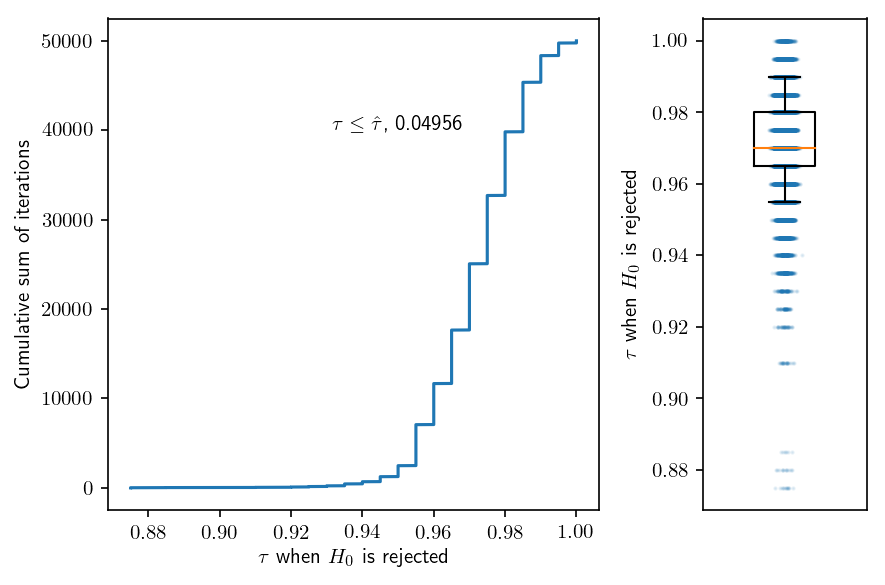

In [65]:
H0_rejection_taus = np.array([x['tau'] for x in h])
H0_rejection_taus.sort()
fig = plt.figure(dpi=150)
gs = gridspec.GridSpec(1,2,width_ratios=[3,1])

ax0 = plt.subplot(gs[0])
ax0.plot(H0_rejection_taus,np.arange(len(H0_rejection_taus)))
failure = sum(H0_rejection_taus<=.95)/iterations
t = r"$\tau \leq \hat{\tau}$, " + f"{failure}"
ax0.text(0.95, iterations*0.8,t,usetex=True,ha="center")
ax0.set_xlabel(r'$\tau$ when $H_0$ is rejected')
ax0.set_ylabel('Cumulative sum of iterations')

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

ax1 = plt.subplot(gs[1])
ax1.boxplot(H0_rejection_taus,whis=[5,95],showfliers=False)
ax1.scatter(rand_jitter(np.zeros(iterations)+1+np.random.randn(iterations)*0.01),H0_rejection_taus,alpha=0.1,s=1)
ax1.set_xticks([])
ax1.set_xlim([0.8,1.2])
ax1.set_ylabel(r'$\tau$ when $H_0$ is rejected')

fig.tight_layout()

plt.show()

 We can repeat these for different starting values


In [85]:
r_ML_range = [100,110,120,130,140,150,160,170,180,190,200]
iterations = 50000
pool = multiprocessing.Pool(6) # (in parallel)
tau_range = []
for r_ml in r_ML_range:
    K = r_tot - r_ML
    sample = np.zeros(N_s)
    sample[:K] = 1
    y, h, t = zip(*pool.map(partial(draw_sample, sample=sample),range(iterations)))
    H0_rejection_taus = np.array([x['tau'] for x in h])
    H0_rejection_taus.sort()
    tau_range.append(H0_rejection_taus)  
pool.terminate()

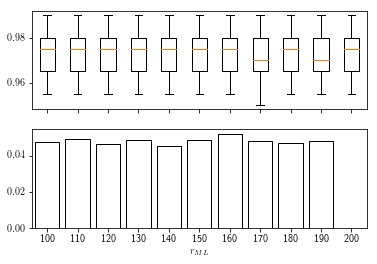

In [95]:
fig, axs = plt.subplots(2,1,sharex=True)
ax = axs[0]
ax.boxplot(tau_range,whis=[5,95],showfliers=False)

ax = axs[1]

failures = [sum(x<=.95)/iterations for x in tau_range] 
ax.bar(np.arange(len(r_ML_range)),failures, color="None",ec="black")
ax.set_xticklabels(r_ML_range)
ax.set_xlabel(r"$r_{ML}")
plt.show()

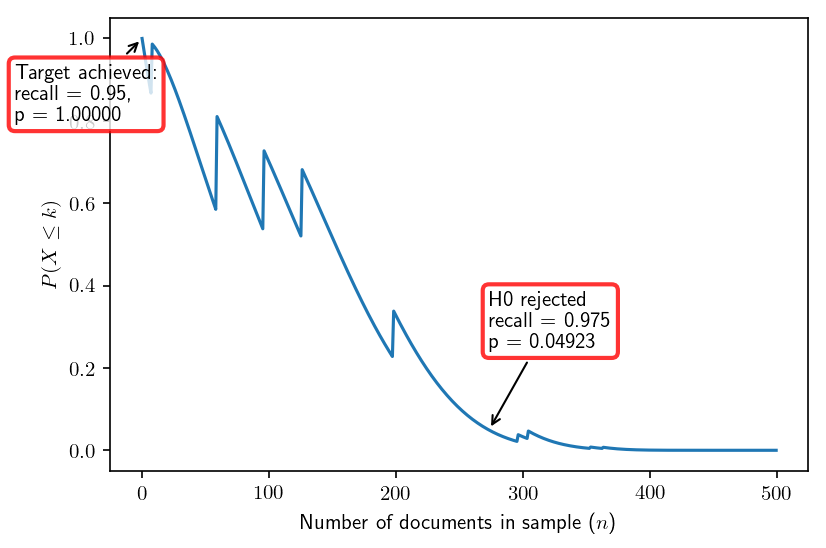

In [93]:
# Let's create a sample


vec_get_K_hat = np.vectorize(get_K_hat)

r_ML = 190
K = r_tot - r_ML
sample = np.zeros(N_s)
sample[:K] = 1
np.random.shuffle(sample)

## We can define a function for simulating drawing from this sample
def draw_sample(x,sample=sample):
    np.random.shuffle(sample) # each time we shuffle the sample
    r_seen = r_ML+sample.cumsum() 
    tau = r_seen/r_tot
    K_hat = vec_get_K_hat(r_seen,tau_target,r_ML)
    p = hypergeom.cdf(sample.cumsum(), N_s, K_hat, np.arange(N_s))
    i = np.argmax(tau>=tau_target) # The first iteration where we 
    target_achievement = {"tau":tau[i], "i":i,"p":p[i], "K_hat":K_hat[i]}
    i = np.argmax(p<0.05)
    H0_rejection = {"tau":tau[i], "i":i,"p":p[i], "K_hat":K_hat[i]}
    return p, H0_rejection, target_achievement

y, H0_rejection, target_achievement = draw_sample(0,sample)

fig, ax = plt.subplots(dpi=150)
bbox_props = dict(boxstyle="round,pad=0.3", ec="red",fc="white",alpha=0.8, lw=2)
ax.annotate(
    f"Target achieved:\nrecall = {target_achievement['tau']},\np = {target_achievement['p']:.5f}",
    (target_achievement['i'],target_achievement['p']),
    (target_achievement['i']-100,target_achievement['p']-0.2),
    bbox=bbox_props,
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3")
)
ax.annotate(
    f"H0 rejected\nrecall = {H0_rejection['tau']}\np = {H0_rejection['p']:.5f}",
    (H0_rejection['i'],H0_rejection['p']),
    (H0_rejection['i'],H0_rejection['p']+0.2),
    bbox=bbox_props,
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3")
)
ax.plot(y)
ax.set_xlabel("Number of documents in sample ($n$)")
ax.set_ylabel("$P(X \leq k)$")

In [91]:
r_seen = r_ML+sample.cumsum() 
tau = r_seen/r_tot
tau

array([0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 ,
       0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 ,
       0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 ,
       0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 ,
       0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 ,
       0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.95 , 0.955, 0.96 , 0.96 ,
       0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.96 ,
       0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.96 ,
       0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.96 ,
       0.96 , 0.96 , 0.965, 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 ,
       0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 ,
       0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 ,
       0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 ,
       0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 , 0.97 ,
       0.975, 0.975,